In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

# I. Chargement et nettoyage des données

## I.1 Descriptions des indicateurs

In [34]:
data2015 = pd.read_csv("./data/2015-building-energy-benchmarking.csv")
data2016 = pd.read_csv("./data/2016-building-energy-benchmarking.csv")

In [35]:
indicators = pd.Series(data2015.columns, name="indicators")
indicators_2016 = pd.Series(data2016.columns, name="indicators_2016")

In [36]:
set(indicators_2016.to_numpy()).difference(indicators.to_numpy())

{'Address',
 'City',
 'Comments',
 'GHGEmissionsIntensity',
 'Latitude',
 'Longitude',
 'State',
 'TotalGHGEmissions',
 'ZipCode'}

In [37]:
set(indicators.to_numpy()).difference(set(indicators_2016.to_numpy()))

{'2010 Census Tracts',
 'City Council Districts',
 'Comment',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Location',
 'OtherFuelUse(kBtu)',
 'SPD Beats',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'Zip Codes'}

Dans la table 2015, Zip Codes semble être générées automatiquement - on ne la garde pas dans un premier temps.

In [38]:
data2015.drop(columns="Zip Codes", inplace=True)

On va donc, dans la table 2015: 
- splitter Location en Latitude, Longitude, Address City State ZipCode
- Retirer Zip Codes

Renommer certaines colonnes pour assurer la correspondance avec 2016, de façon à fusionner les tables
- GHGEmissions(MetricTonsCO2e) (2015) et TotalGHGEmissions (2016) sont en fait les mêmes colonnes
- GHGEmissionsIntensity(kgCO2e/ft2) et GHGEmissionsIntensity sont les mêmes colonnes

In [39]:
from ast import literal_eval # module pour évaluer une expression et renvoyer l'objet correspondant

data2015["Location"] = data2015["Location"].apply(literal_eval) # convertit les str en dict
df = pd.json_normalize(data2015["Location"]) # Normalize semi-structured JSON data into a flat table.
df.human_address = df.human_address.apply(literal_eval)
df2 = pd.json_normalize(df.human_address)
loc = data2015.columns.get_loc("Location") # Indice de colonne de la variable Location
data2015.drop(columns="Location", inplace=True)
d = pd.concat([df.drop(columns="human_address"), df2], axis=1) # nouveau dataframe à partir des colonnes extraites

for c in d.columns[::-1]: # Insertion des colonnes dans le df original, une par une
    data2015.insert(loc, c, d[c])

data2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,latitude,longitude,address,city,...,GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,...,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,47.61310583,-122.33335756,724 PINE ST,SEATTLE,...,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,...,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,47.61421585,-122.33660889,620 STEWART ST,SEATTLE,...,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,47.6137544,-122.3409238,401 LENORA ST,SEATTLE,...,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0


In [40]:
data2015.rename(columns={"GHGEmissions(MetricTonsCO2e)":"TotalGHGEmissions",
                         "GHGEmissionsIntensity(kgCO2e/ft2)":"GHGEmissionsIntensity",
                         "Comment":"Comments",
                         "latitude":"Latitude", 
                         "longitude":"Longitude", 
                         "address":"Address", 
                         "city":"City",
                         "state":"State"}, inplace=True)

In [41]:
data = pd.concat([data2015, data2016])

## I.2 Nettoyage

On supprime les colonnes remplies à moins de 50%

In [42]:
missing = data.notna().sum()/data.shape[0]
data = data.drop(columns=missing[missing<0.5].index)

On se débarasse des NaN

In [43]:
data.dropna(subset=["ENERGYSTARScore"], how="any", inplace=True)

In [44]:
data.dropna(subset=["ListOfAllPropertyUseTypes", 
                        "LargestPropertyUseType", 
                        "LargestPropertyUseTypeGFA"], how="all", inplace=True)

In [45]:
data.dropna(subset=[c for c in data.columns if c!="ZipCode"], how="any", inplace=True)

# II. Analyse exploratoire

## II.1 Variables qualitatives et variables quantitatives

In [46]:
mask = data.dtypes!="object"
numerical_features = mask[mask].index
numerical_features

Index(['OSEBuildingID', 'DataYear', 'CouncilDistrictCode', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'ZipCode'],
      dtype='object')

In [47]:
mask = data.dtypes=="object"
categorical_features = mask[mask].index
categorical_features

Index(['BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'TaxParcelIdentificationNumber', 'Latitude', 'Longitude', 'Address',
       'City', 'State', 'Neighborhood', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'DefaultData', 'ComplianceStatus'],
      dtype='object')

In [48]:
# Variables numériques catégorielles
num_categorical = pd.Index(["OSEBuildingID", 
                 "DataYear", 
                 "CouncilDistrictCode", 
                 "YearBuilt", 
                 "Latitude",
                 "Longitude", 
                 "ZipCode"])

# On récupère ces colonnes dans la liste des indicateurs catégoriels
categorical_features = categorical_features.append(num_categorical)

In [49]:
# Targets: variables cibles
targets = pd.Index(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"])

# On crée l'index quantitative_features qui ne contient que les variables quantitatives
quantitative_features = pd.Index([c for c in numerical_features if (c not in categorical_features) & (c not in targets)])

## II.2 Variables quantitatives

On souhaite se passer des relevés annuels. On doit donc arriver à faire des prédictions sur les variables "targets" sans les variables "SiteEUI, SiteEUIWN, SourceEUI, SourceEUIWN, SiteEnergyUseWN, SteamUse, Electricity, NaturalGas, GHGEmissionsIntensity".

In [50]:
# On exclut les indicateurs liés à l'énergie consommée dans la liste des indicateurs quantitatifs
quantitative_features = pd.Index(['NumberofBuildings',
                                  'NumberofFloors',
                                  'PropertyGFATotal',
                                  'PropertyGFAParking',
                                  'PropertyGFABuilding(s)',
                                  'LargestPropertyUseTypeGFA'])
targets = pd.Index(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"])

### II.2.1 Distribution des variables quantitatives

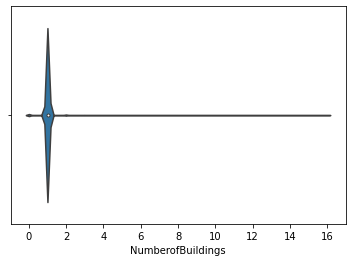

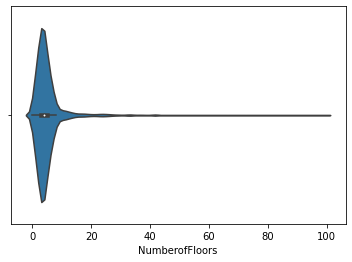

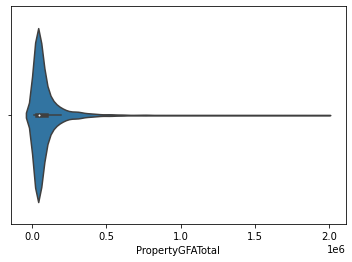

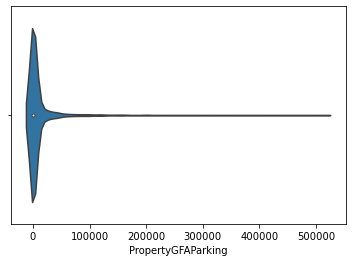

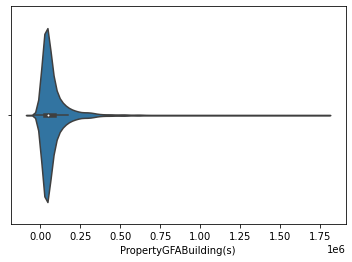

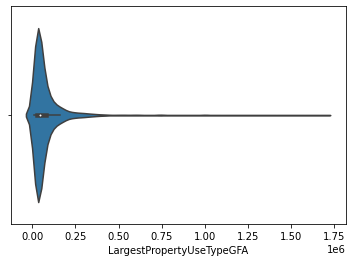

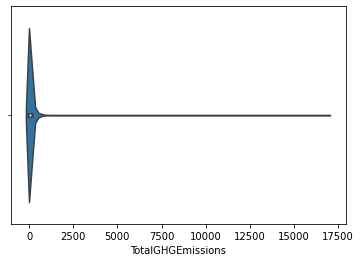

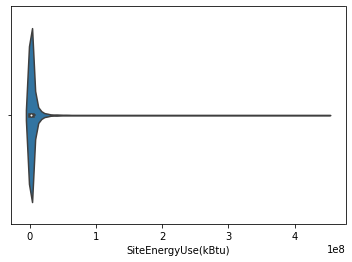

In [51]:
for c in quantitative_features.append(targets):
    sns.violinplot(x=data[c])
    plt.xlabel(c)
    plt.show()

### II.2.2 outliers

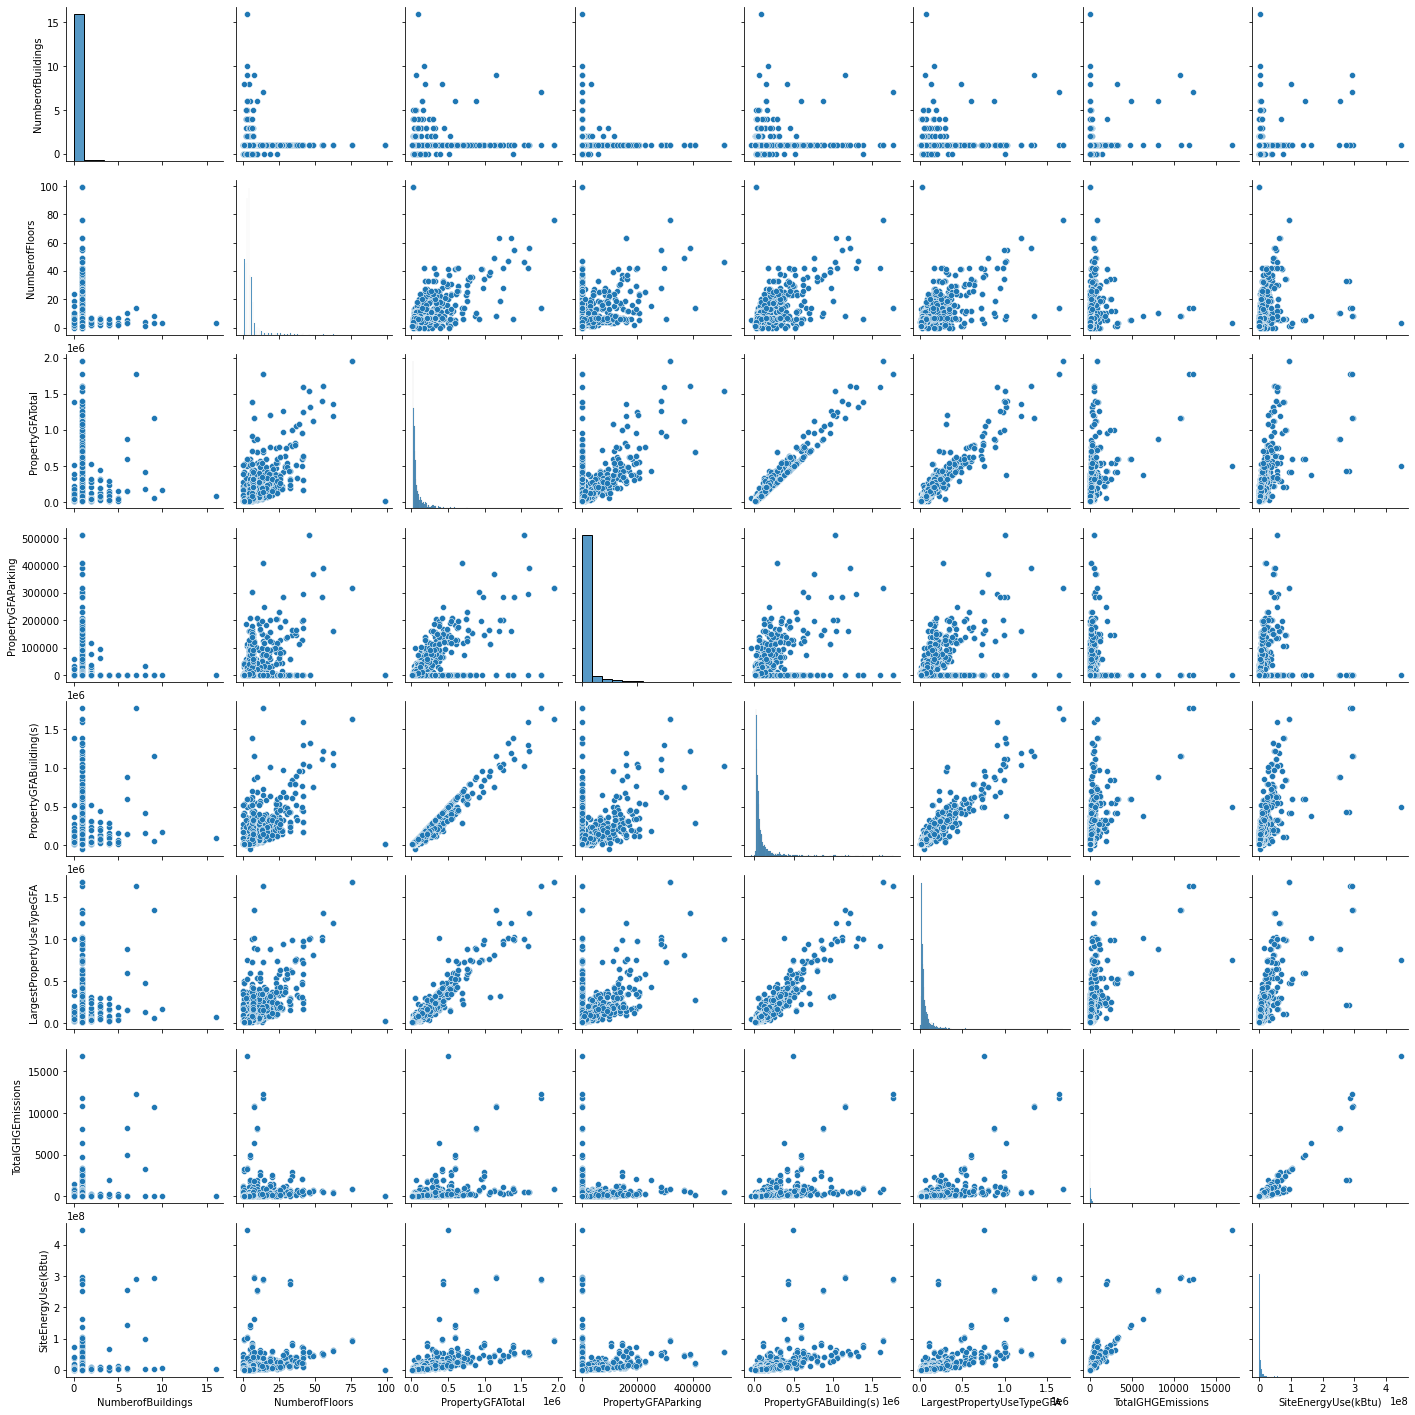

In [52]:
sns.pairplot(data[quantitative_features.append(targets)])

In [53]:
# On exclut les outliers
data = data[data.NumberofFloors<data.NumberofFloors.quantile(0.99)]
data = data[data["NumberofBuildings"]<data["NumberofBuildings"].quantile(0.99)]
data = data[data["TotalGHGEmissions"]<data["TotalGHGEmissions"].quantile(0.99)]
data = data[data["SiteEnergyUse(kBtu)"]<data["SiteEnergyUse(kBtu)"].quantile(0.99)]

PropertyGFATotal semble être la somme de PropertyGFAParking et PropertyGFABuilding(s): On n'utilisera pas PropertyGFATotal

In [54]:
data.drop(columns="PropertyGFATotal", inplace=True)
quantitative_features = quantitative_features.drop("PropertyGFATotal")

In [55]:
# On va travailler sur chacun des jeux de données séparément.
df2015 = data[data.DataYear==2015]
df2015.index = pd.Index(range(0, df2015.shape[0]))
df2016 = data[data.DataYear==2016]
df2016.index = pd.Index(range(0, df2016.shape[0]))

### II.3 Variables catégorielles

### II.3.1 Etude des corrélations

In [56]:
cat_feats = pd.DataFrame(data={"name":categorical_features, "nombre de modalités":data[categorical_features].nunique()})
cat_feats

,name,nombre de modalités
BuildingType,BuildingType,7
PrimaryPropertyType,PrimaryPropertyType,25
PropertyName,PropertyName,4630
TaxParcelIdentificationNumber,TaxParcelIdentificationNumber,2726
Latitude,Latitude,4431
Longitude,Longitude,4292
Address,Address,4551
City,City,2
State,State,1
Neighborhood,Neighborhood,18


Variables d'intérêt: BuildingType, PrimaryPropertyType, LargestPropertyUseType, YearBuilt

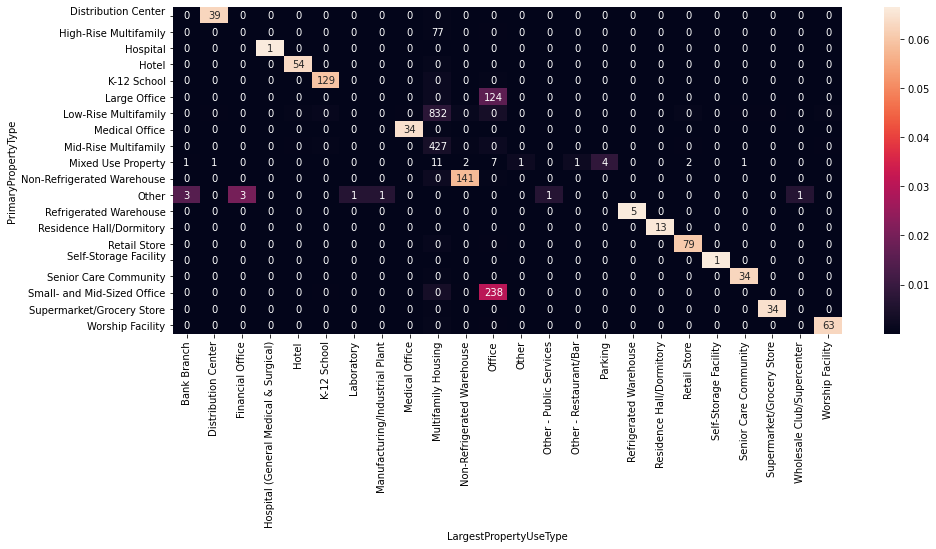

In [57]:
def contingence(Var1, Var2, df):
    X=Var1
    Y=Var2
    cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")

    tx = cont.loc[:,["Total"]]
    ty = cont.loc[["Total"],:]
    n = len(df)
    indep = tx.dot(ty) / n

    c = cont.fillna(0) # On remplace les valeurs nulles par 0
    measure = (c-indep)**2/indep
    xi_n = measure.sum().sum()
    table = measure/xi_n
    plt.figure(figsize=(15, 6))
    sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1], fmt=".0f")

contingence("PrimaryPropertyType", "LargestPropertyUseType", df2015)

On va grouper les YearBuilt par décennies

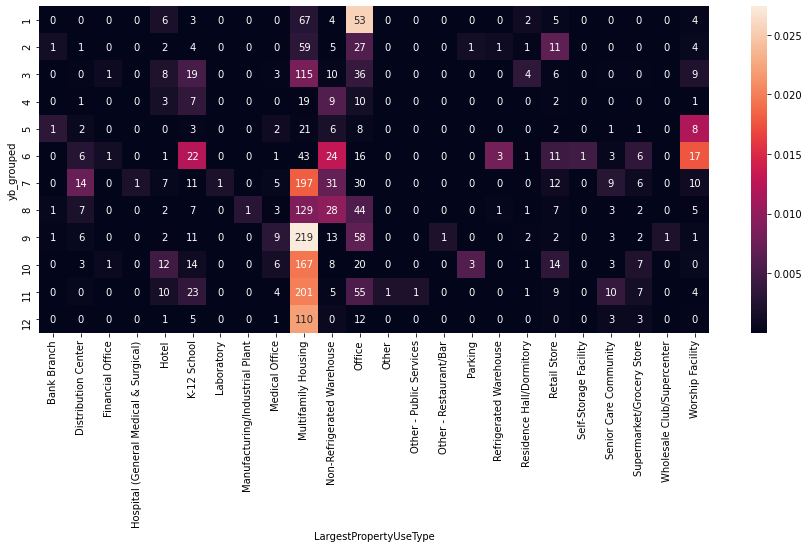

In [58]:
slice = 10 # décennies
bins = [1900+i*slice for i in range(13)]
yb_grouped = np.digitize(data.YearBuilt, bins)
yb_grouped = pd.Series(data=yb_grouped, name="yb_grouped")

df1 = pd.concat([df2015, yb_grouped], axis=1)
contingence("yb_grouped", "LargestPropertyUseType", df1)

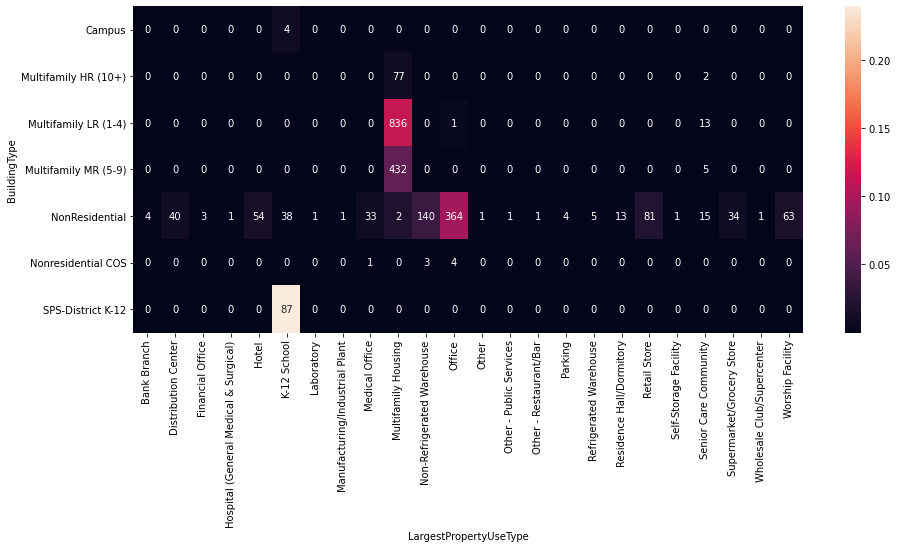

In [59]:
contingence("BuildingType", "LargestPropertyUseType", df1)

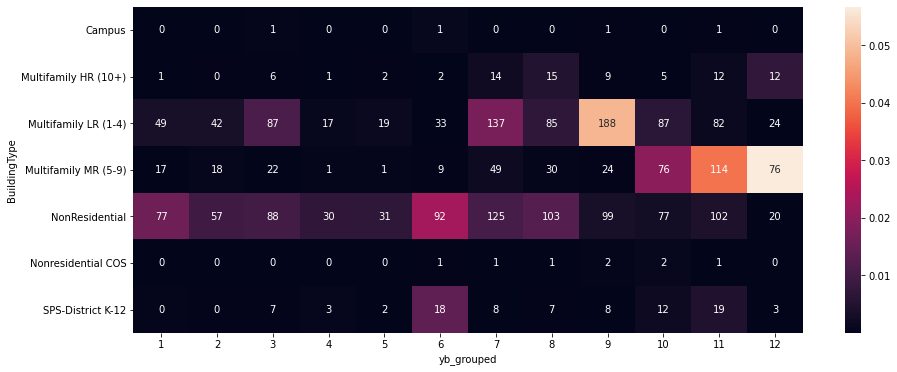

In [60]:
contingence("BuildingType", "yb_grouped", df1)

In [61]:
# On regroupe TotalGHGEmissions en 10 catégories
deciles = df2015["TotalGHGEmissions"].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# On groupe TotalGHGEmissions en 10 catégories
bins = deciles[4:-1].to_numpy()
cat_TotalGHG = np.digitize(df2015.TotalGHGEmissions, bins)

# Création d'une Series pour pouvoir concatener
cat_TotalGHG = pd.Series(data=cat_TotalGHG, name="cat_TotalGHG", index=range(0, cat_TotalGHG.shape[0]))

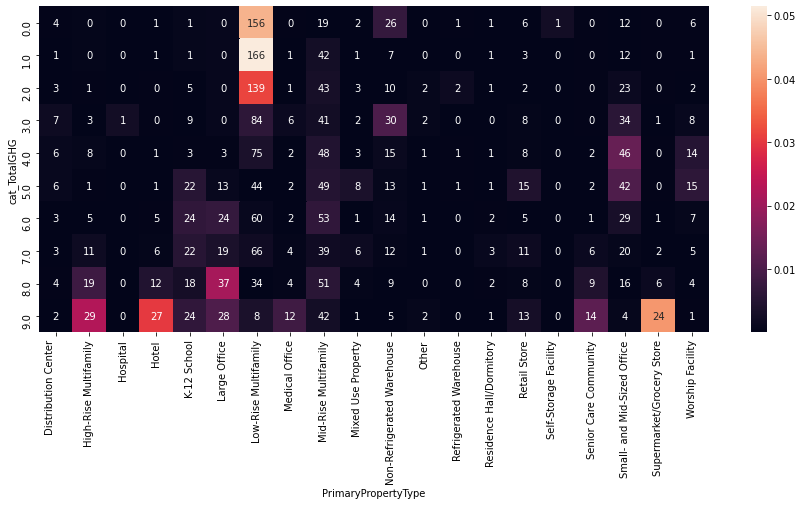

In [62]:
df1 = pd.concat([df1, cat_TotalGHG], axis=1)
contingence("cat_TotalGHG", "PrimaryPropertyType", df1)

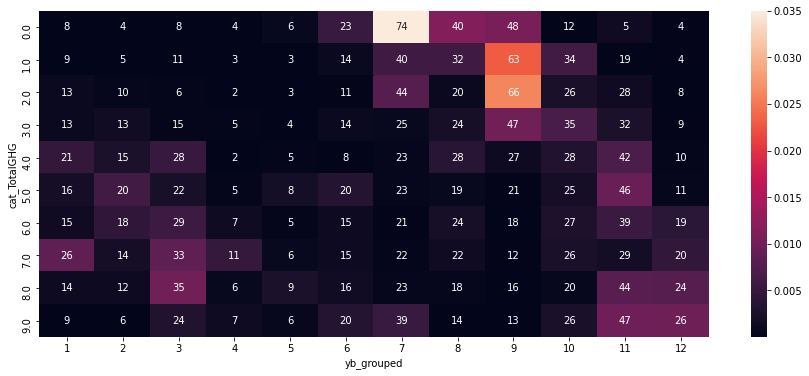

In [63]:
contingence("cat_TotalGHG", "yb_grouped", df1)

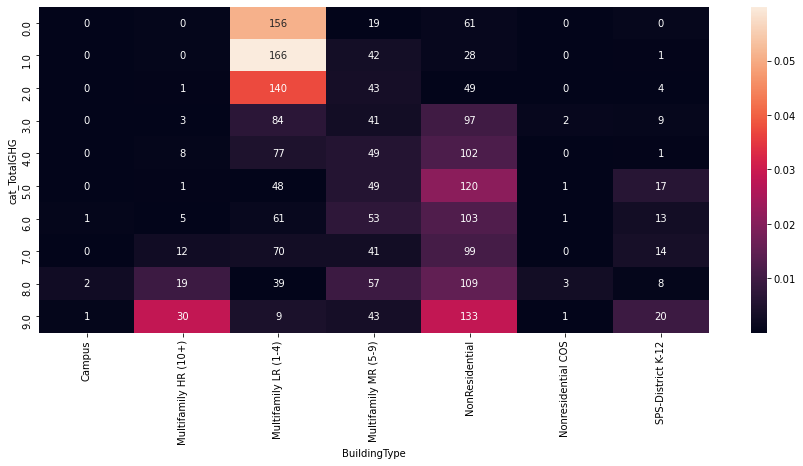

In [64]:
contingence("cat_TotalGHG", "BuildingType", df1)

# III Régressions linéaires